In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
import json
import random
import pickle
from joblib import Memory
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [5]:
# Configuration
imgs_path = "large_files\\fashion-dataset\\fashion-dataset\\images"
imgs_model_width, imgs_model_height = 299, 299
BATCH_SIZE = 20
CHUNK_SIZE = 300
TOP_N = 5
TEST_SIZE = 0.1


def resize_and_pad_image(image_path, target_size):
    try:
        img = Image.open(image_path)
        original_width, original_height = img.size
        aspect_ratio = original_width / original_height

        if aspect_ratio > 1:
            new_width = target_size[0]
            new_height = int(new_width / aspect_ratio)
        else:
            new_height = target_size[1]
            new_width = int(new_height * aspect_ratio)

        img = img.resize((new_width, new_height), Image.LANCZOS)

        new_img = Image.new("RGB", target_size, (255, 255, 255))
        new_img.paste(img, ((target_size[0] - new_width) // 2,
                            (target_size[1] - new_height) // 2))

        return new_img
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None


'''
This function is used to generate batches of images to be fed into the model. 20 images are loaded at a time.
'''
def image_batch_generator(image_files, batch_size):
    for i in range(0, len(image_files), batch_size):
        batch_files = image_files[i:i + batch_size]
        batch_images = []
        for img_path in batch_files:
            img = resize_and_pad_image(img_path, (imgs_model_width, imgs_model_height))
            if img is not None:
                batch_images.append(img_to_array(img))
        batch_images = np.array(batch_images)
        batch_images = preprocess_input(batch_images)
        yield batch_images

'''
Extract features from images using the Xception model. The features are extracted in chunks of 300 images.
'''

def create_model():
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(imgs_model_width, imgs_model_height, 3))
    
    # Fine-tuning: Unfreeze the last few layers of the base model
    for layer in base_model.layers[-15:]:
        layer.trainable = True
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    
    # Compile the model with a lower learning rate
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    
    return model

Extract features using Imagenet pre-trained model + attaching Global Pooling layer to get the embeddings. 

In [6]:
def extract_features():
    model = create_model()
    feat_extractor = Model(inputs=model.input, outputs=model.output)

    image_files = [os.path.join(imgs_path, f) for f in os.listdir(imgs_path) if f.endswith(".jpg")]
    
    # Train-test split
    train_files, test_files = train_test_split(image_files, test_size=TEST_SIZE, random_state=42)
    
    all_features = []
    print("Total number of training images:", len(train_files))

    for batch_images in tqdm(image_batch_generator(train_files, BATCH_SIZE), total=len(train_files) // BATCH_SIZE, desc="Extracting Features"):
        batch_features = feat_extractor.predict(batch_images, verbose=0)
        all_features.extend(batch_features)

    all_features = np.array(all_features)
    
    # Save features and file lists
    np.save('large_files\\ml\\all_features.npy', all_features)
    with open('large_files\\ml\\train_files.pkl', 'wb') as f:
        pickle.dump(train_files, f)
    with open('large_files\\ml\\test_files.pkl', 'wb') as f:
        pickle.dump(test_files, f)
    
    return feat_extractor, all_features, train_files, test_files

# Run feature extraction
feat_extractor, all_features, train_files, test_files = 

extract_features()

# Save feature extractor
feat_extractor.save('large_files\\ml\\feature_extractor_model.keras')

Total number of training images: 39996


Extracting Features: 2000it [1:12:37,  2.18s/it]                          


In [7]:
all_features.shape

(39996, 2048)

We are applying PCA in order to reduce the features and we want to focuse on data that can explain 95% of the whole data.

In [9]:
def apply_pca(all_features, variance_threshold=0.95):
    print("Applying PCA for dimensionality reduction...")
    
    # Find number of components to keep desired variance
    pca = PCA(n_components=variance_threshold, svd_solver='full')
    pca.fit(all_features)
    n_components = pca.n_components_
    
    print(f"Using {n_components} components to explain {variance_threshold*100}% of variance")
    
    # Transform the data
    all_features_pca = pca.transform(all_features)
    
    print(f"PCA reduced dimensions from {all_features.shape[1]} to {all_features_pca.shape[1]}")
    print(f"Variance explained: {pca.explained_variance_ratio_.sum():.4f}")
    
    # Plot variance explained
    plt.figure(figsize=(10, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Variance Explained by PCA Components')
    plt.axhline(y=variance_threshold, color='r', linestyle='--')
    plt.axvline(x=n_components, color='r', linestyle='--')
    plt.show()
    
    return pca, all_features_pca

Applying PCA for dimensionality reduction...
Using 743 components to explain 95.0% of variance
PCA reduced dimensions from 2048 to 743
Variance explained: 0.9500


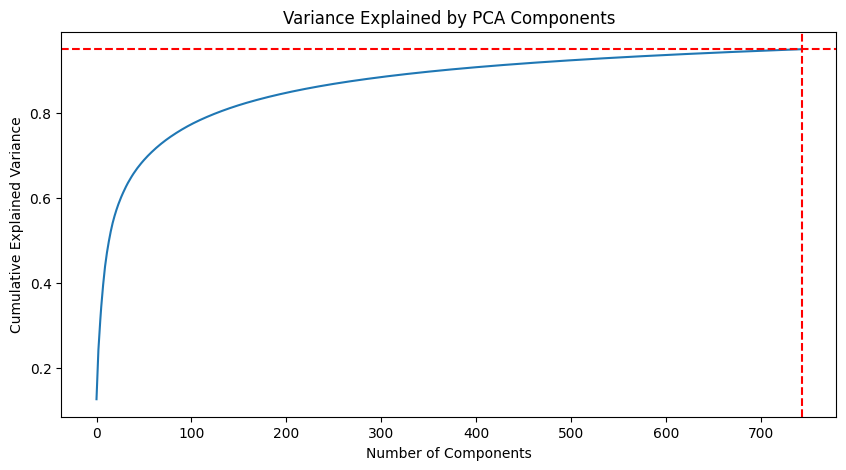

In [10]:
pca, all_features_pca = apply_pca(all_features)

# Save PCA model and transformed features
with open('large_files\\ml\\pca_model.pkl', 'wb') as file:
    pickle.dump(pca, file)
np.save('large_files\\ml\\all_features_pca.npy', all_features_pca)

Used cosine and euclidean disrances in order to get vector explainability in order to get item similarities. 

In [11]:
def calculate_similarities(all_features_pca, train_files):
    print("Calculating similarities...")
    top_similarities_cosine = {}
    top_similarities_euclidean = {}

    for i in tqdm(range(0, len(train_files), CHUNK_SIZE), desc="Processing Image Chunks"):
        chunk_features_pca = all_features_pca[i:i + CHUNK_SIZE]
        chunk_similarities_cosine = cosine_similarity(chunk_features_pca, all_features_pca)
        chunk_similarities_euclidean = -euclidean_distances(chunk_features_pca, all_features_pca)

        for idx, (similarities_cosine, similarities_euclidean) in enumerate(zip(chunk_similarities_cosine, chunk_similarities_euclidean)):
            top_indices_cosine = np.argsort(similarities_cosine)[::-1][:TOP_N + 1]
            top_indices_euclidean = np.argsort(similarities_euclidean)[::-1][:TOP_N + 1]
            
            top_similarities_cosine[train_files[i + idx]] = [(train_files[j], similarities_cosine[j]) for j in top_indices_cosine if j != i + idx]
            top_similarities_euclidean[train_files[i + idx]] = [(train_files[j], similarities_euclidean[j]) for j in top_indices_euclidean if j != i + idx]

    # Save similarities
    with open('large_files\\ml\\top_similarities_cosine.pkl', 'wb') as file:
        pickle.dump(top_similarities_cosine, file)
    with open('large_files\\ml\\top_similarities_cosine.json', 'w') as file:
        json.dump({k: [(v[0], float(v[1])) for v in vs] for k, vs in top_similarities_cosine.items()}, file)
    with open('large_files\\ml\\top_similarities_euclidean.pkl', 'wb') as file:
        pickle.dump(top_similarities_euclidean, file)
    with open('large_files\\ml\\top_similarities_euclidean.json', 'w') as file:
        json.dump({k: [(v[0], float(v[1])) for v in vs] for k, vs in top_similarities_euclidean.items()}, file)
    
    return top_similarities_cosine, top_similarities_euclidean

# Load PCA features and image files if not in memory
if 'all_features_pca' not in locals():
    all_features_pca = np.load('large_files\\ml\\all_features_pca.npy')
if 'train_files' not in locals():
    with open('large_files\\ml\\train_files.pkl', 'rb') as f:
        train_files = pickle.load(f)


# Calculate similarities
top_similarities_cosine, top_similarities_euclidean = calculate_similarities(all_features_pca, train_files)

Calculating similarities...


Processing Image Chunks: 100%|██████████| 134/134 [05:09<00:00,  2.31s/it]


Evaluating:   0%|          | 0/4445 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 4445/4445 [43:44<00:00,  1.69it/s]  



Results for pca_cosine:
Average PRECISION: 0.9327
Average MRR: 0.9695
Average CATEGORY_HIT: 0.9867


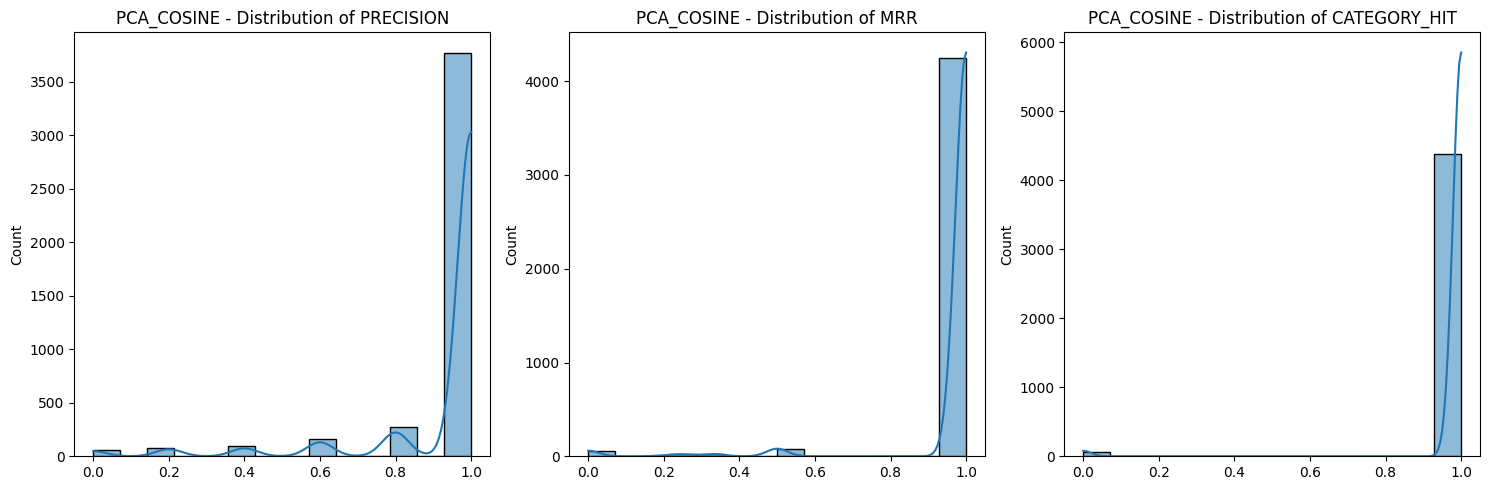


Results for pca_euclidean:
Average PRECISION: 0.9282
Average MRR: 0.9688
Average CATEGORY_HIT: 0.9854


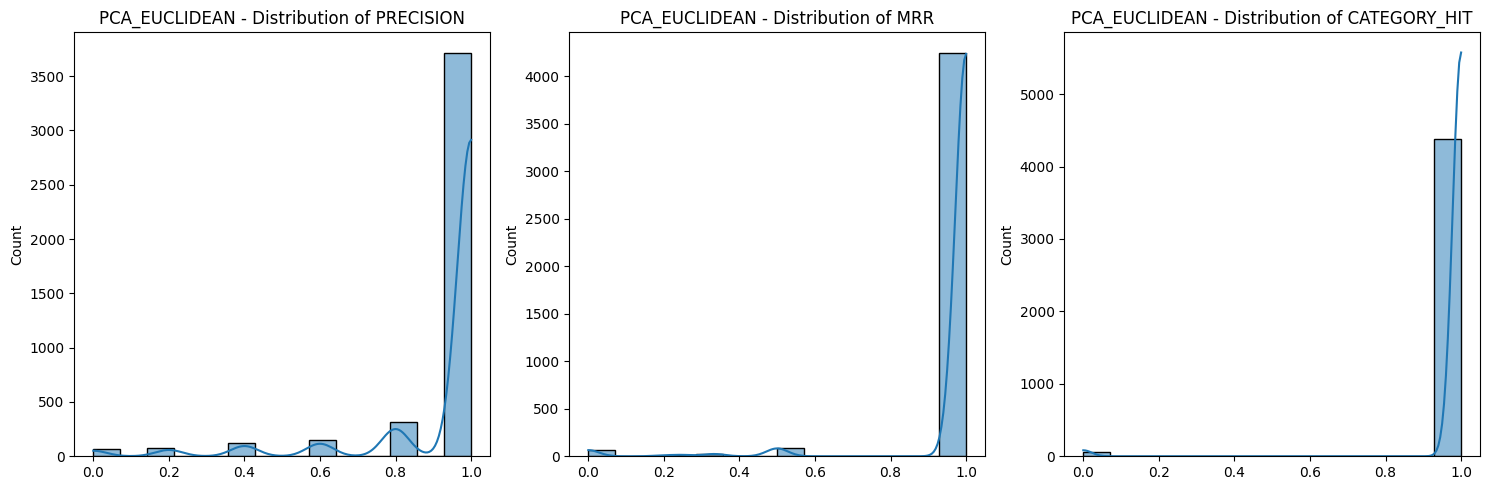


Results for no_pca_cosine:
Average PRECISION: 0.9296
Average MRR: 0.9696
Average CATEGORY_HIT: 0.9858


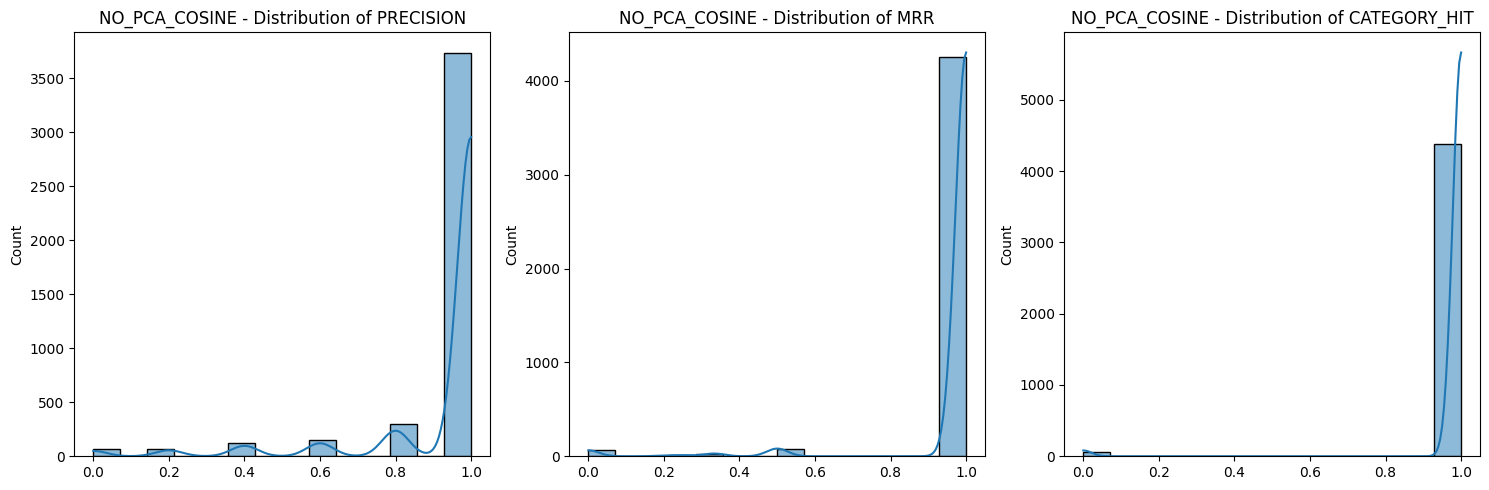


Results for no_pca_euclidean:
Average PRECISION: 0.9269
Average MRR: 0.9681
Average CATEGORY_HIT: 0.9856


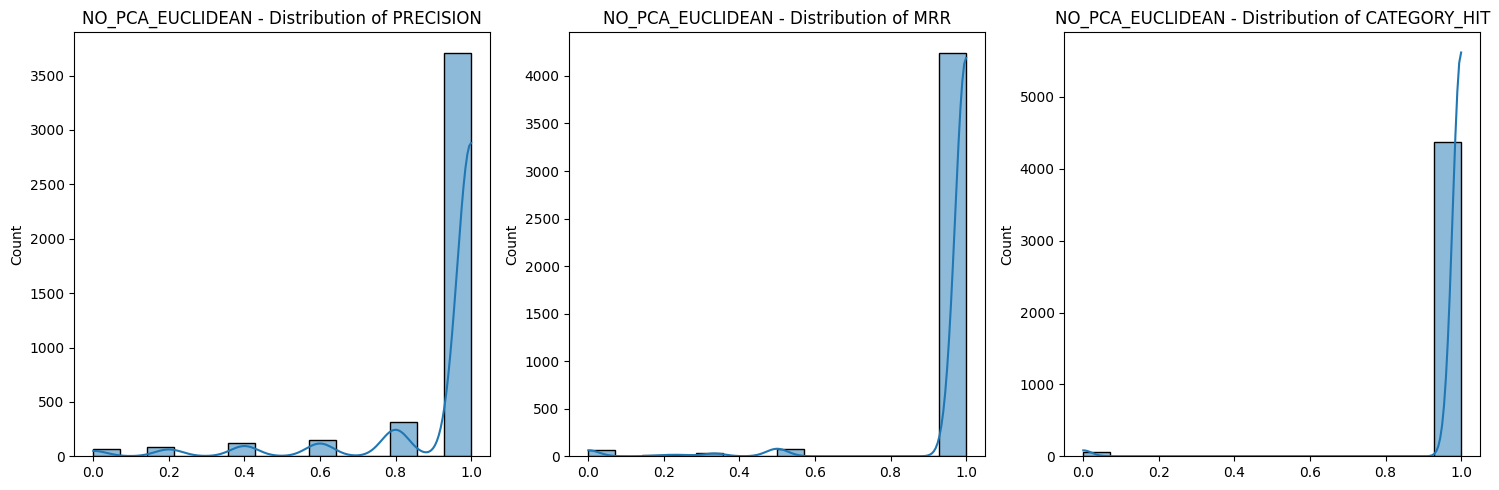

In [18]:
def evaluate_recommendation_system(test_files, style_df, feat_extractor, pca, all_features_pca, all_features, train_files):
    # Preprocess style_df
    style_dict = style_df.set_index('id')['subCategory'].to_dict()
    subcategory_to_ids = defaultdict(set)
    for id_, subcategory in style_dict.items():
        subcategory_to_ids[subcategory].add(str(id_))

    def extract_features(image_path, feat_extractor):
        img = resize_and_pad_image(image_path, (imgs_model_width, imgs_model_height))
        if img is None:
            return None
        img_array = img_to_array(img)
        img_array = img_array.reshape((1, img_array.shape[0], img_array.shape[1], img_array.shape[2]))
        img_array = preprocess_input(img_array)
        features = feat_extractor.predict(img_array, verbose=0)
        return features.reshape((-1))

    def process_image(img_path):
        img_id = os.path.basename(img_path).split('.')[0]
        try:
            img_features = extract_features(img_path, feat_extractor)
            if img_features is None:
                return None
            
            img_features_pca = pca.transform(img_features.reshape(1, -1))
            
            # Calculate similarities
            similarities = {
                'pca_cosine': cosine_similarity(img_features_pca, all_features_pca).flatten(),
                'pca_euclidean': -euclidean_distances(img_features_pca, all_features_pca).flatten(),
                'no_pca_cosine': cosine_similarity(img_features.reshape(1, -1), all_features).flatten(),
                'no_pca_euclidean': -euclidean_distances(img_features.reshape(1, -1), all_features).flatten()
            }
            
            results = {}
            for method, sim in similarities.items():
                top_indices = np.argsort(sim)[::-1][:TOP_N]
                retrieved = [(train_files[j], sim[j]) for j in top_indices]
                retrieved_ids = [os.path.basename(img_path).split('.')[0] for img_path, _ in retrieved]
                
                relevant_article_type = style_dict.get(int(img_id))
                if relevant_article_type is None:
                    return None

                relevant_ids = subcategory_to_ids[relevant_article_type]
                
                # Precision@k
                precision = len(set(retrieved_ids) & relevant_ids) / len(retrieved_ids)

                # MRR
                mrr = next((1 / (i + 1) for i, rid in enumerate(retrieved_ids) if rid in relevant_ids), 0)

                # Category Hit Rate
                category_hit = int(any(rid in relevant_ids for rid in retrieved_ids))

                results[method] = (precision, mrr, category_hit)

            return results
        except Exception as e:
            print(f"Error processing image {img_id}: {e}")
            return None

    results = defaultdict(lambda: defaultdict(list))
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        future_to_img = {executor.submit(process_image, img_path): img_path for img_path in test_files}
        for future in tqdm(as_completed(future_to_img), total=len(test_files), desc="Evaluating"):
            result = future.result()
            if result is not None:
                for method, metrics in result.items():
                    results[method]['precision'].append(metrics[0])
                    results[method]['mrr'].append(metrics[1])
                    results[method]['category_hit'].append(metrics[2])

    if not results:
        print("No valid results were obtained. Check if the image processing is working correctly.")
        return

    # Print results and plot distributions
    for method in results:
        print(f"\nResults for {method}:")
        for metric in ['precision', 'mrr', 'category_hit']:
            avg_value = np.mean(results[method][metric])
            print(f"Average {metric.upper()}: {avg_value:.4f}")

        plt.figure(figsize=(15, 5))
        for i, metric in enumerate(['precision', 'mrr', 'category_hit'], 1):
            plt.subplot(1, 3, i)
            sns.histplot(results[method][metric], kde=True)
            plt.title(f'{method.upper()} - Distribution of {metric.upper()}')
        plt.tight_layout()
        plt.show()

# Load necessary data
style_df = pd.read_csv('fashion-dataset\styles.csv', on_bad_lines='skip')
style_df = style_df[['id', 'subCategory', 'masterCategory']]

with open('ml\\test_files.pkl', 'rb') as f:
    test_files = pickle.load(f)

with open('ml\\train_files.pkl', 'rb') as f:
    train_files = pickle.load(f)

all_features_pca = np.load('ml\\all_features_pca.npy')
all_features = np.load('ml\\all_features.npy')  # Make sure you have this file

with open('ml\\pca_model.pkl', 'rb') as f:
    pca = pickle.load(f)

feat_extractor = tf.keras.models.load_model('ml\\feature_extractor_model.keras')

# Ensure these are defined
imgs_model_width, imgs_model_height = 299, 299
TOP_N = 5

# Make sure these functions are available in your global scope
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image

def resize_and_pad_image(image_path, target_size):
    try:
        img = Image.open(image_path)
        original_width, original_height = img.size
        aspect_ratio = original_width / original_height

        if aspect_ratio > 1:
            new_width = target_size[0]
            new_height = int(new_width / aspect_ratio)
        else:
            new_height = target_size[1]
            new_width = int(new_height * aspect_ratio)

        img = img.resize((new_width, new_height), Image.LANCZOS)

        new_img = Image.new("RGB", target_size, (255, 255, 255))
        new_img.paste(img, ((target_size[0] - new_width) // 2,
                            (target_size[1] - new_height) // 2))

        return new_img
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Evaluate Recommendation System
evaluate_recommendation_system(test_files, style_df, feat_extractor, pca, all_features_pca, all_features, train_files)

-----------------------------------------------------------------------
Original product:


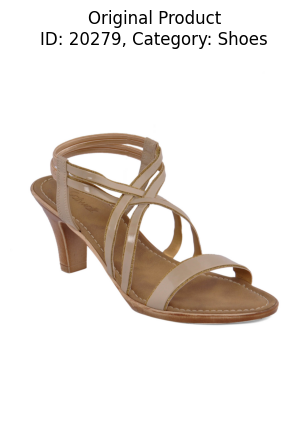

-----------------------------------------------------------------------
Most similar products:


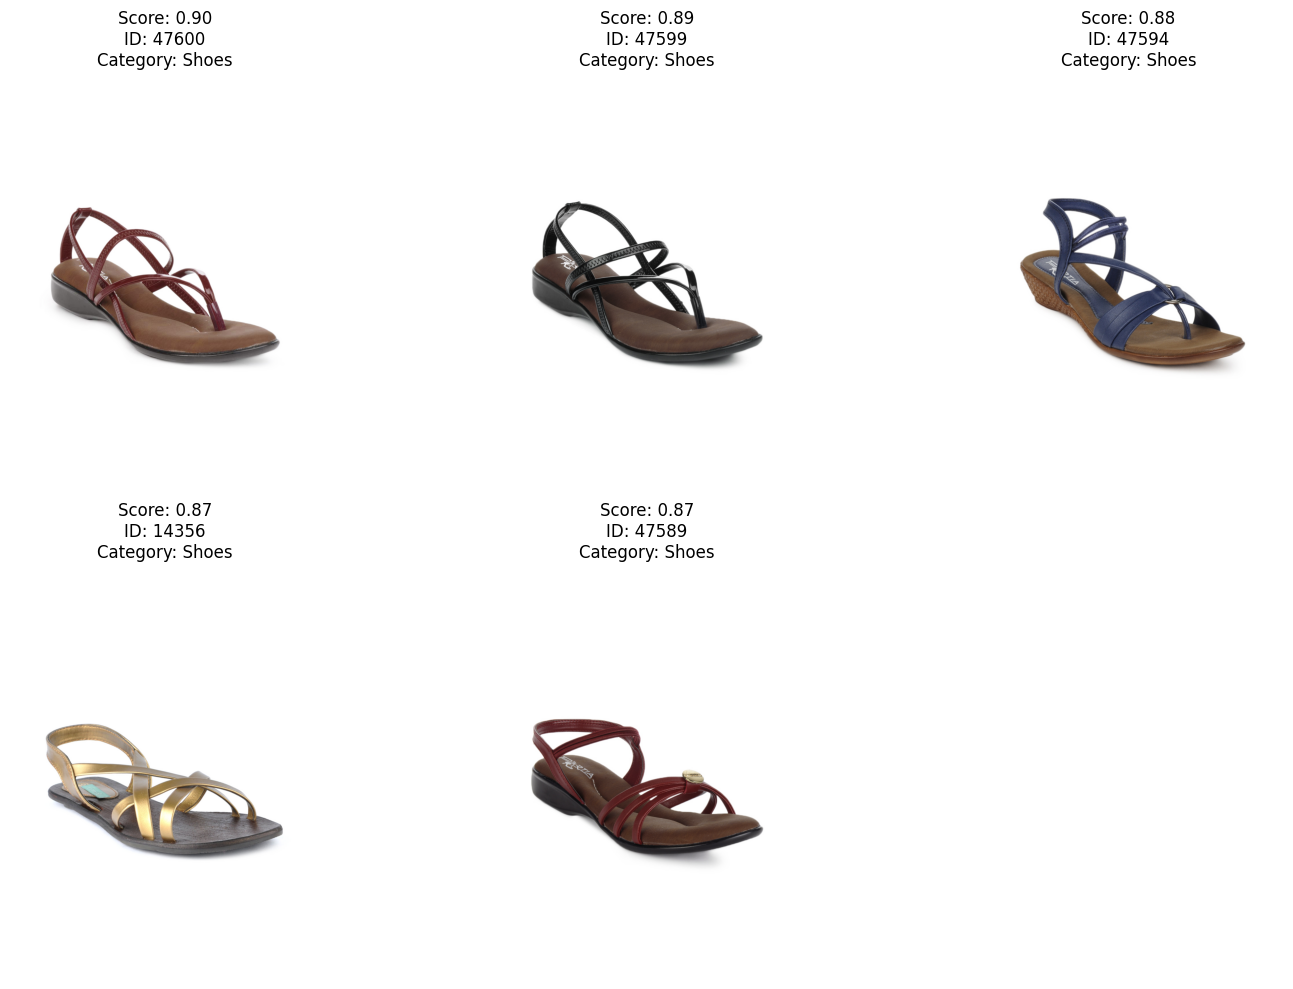

In [19]:
def retrieve_and_display_most_similar_products(given_img, top_similarities_cosine, style_df):
    print("-----------------------------------------------------------------------")
    print("Original product:")
    original = Image.open(given_img)
    plt.figure(figsize=(5, 5))
    plt.imshow(original)
    img_id = os.path.basename(given_img).split('.')[0]
    category = style_df[style_df['id'] == int(img_id)]['subCategory'].iloc[0] if int(img_id) in style_df['id'].values else 'Unknown'
    plt.title(f"Original Product\nID: {img_id}, Category: {category}")
    plt.axis('off')
    plt.show()

    print("-----------------------------------------------------------------------")
    print("Most similar products:")
    if given_img in top_similarities_cosine:
        closest_imgs = top_similarities_cosine[given_img][:TOP_N]
        rows = 2
        columns = 3

        plt.figure(figsize=(5 * columns, 5 * rows))
        for i, (img_path, score) in enumerate(closest_imgs, start=1):
            plt.subplot(rows, columns, i)
            img = Image.open(img_path)
            plt.imshow(img)
            img_id = os.path.basename(img_path).split('.')[0]
            category = style_df[style_df['id'] == int(img_id)]['subCategory'].iloc[0] if int(img_id) in style_df['id'].values else 'Unknown'
            plt.title(f"Score: {score:.2f}\nID: {img_id}\nCategory: {category}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        return closest_imgs
    else:
        print("No data available for this image.")
        return []

# Example Retrieval
retrieved = retrieve_and_display_most_similar_products(train_files[213], top_similarities_cosine, style_df)

1/1 [==============================] - 1s 970ms/step
-----------------------------------------------------------------------
Input product:


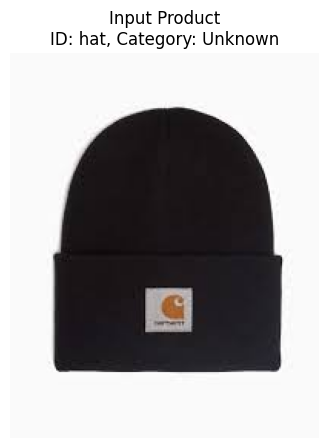

-----------------------------------------------------------------------
Most similar products:


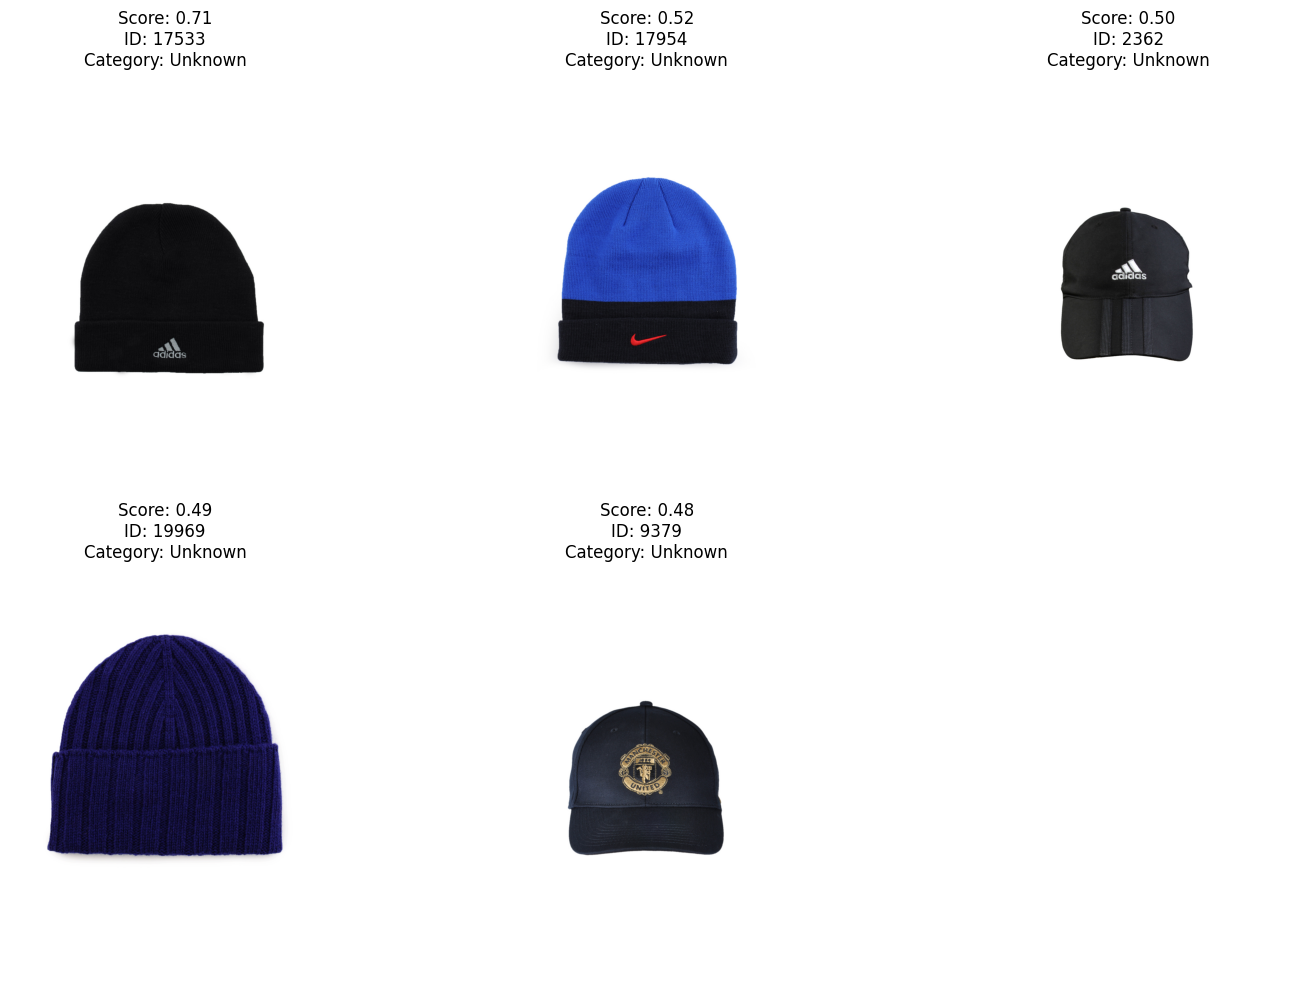

In [22]:
def load_and_preprocess_image(image_path, target_size):
    try:
        img = Image.open(image_path)
        original_width, original_height = img.size
        aspect_ratio = original_width / original_height

        if aspect_ratio > 1:
            new_width = target_size[0]
            new_height = int(new_width / aspect_ratio)
        else:
            new_height = target_size[1]
            new_width = int(new_height * aspect_ratio)

        img = img.resize((new_width, new_height), Image.LANCZOS)
        new_img = Image.new("RGB", target_size, (255, 255, 255))
        new_img.paste(img, ((target_size[0] - new_width) // 2, (target_size[1] - new_height) // 2))

        return new_img
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

def get_image_features(image_path, model, pca):
    preprocessed_image = load_and_preprocess_image(image_path, (imgs_model_width, imgs_model_height))
    if preprocessed_image is None:
        return None
    img_array = img_to_array(preprocessed_image)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    features = model.predict(img_array)
    features_pca = pca.transform(features)
    return features_pca

def find_similar_images_for_unseen(image_path, feat_extractor, pca, all_features_pca, train_files, top_n=5):
    image_features_pca = get_image_features(image_path, feat_extractor, pca)
    if image_features_pca is None:
        print("Error processing the input image.")
        return None

    # Calculate similarities
    cosine_similarities = cosine_similarity(image_features_pca, all_features_pca)[0]
    euclidean_similarities = -euclidean_distances(image_features_pca, all_features_pca)[0]

    # Get top N similar images
    top_indices_cosine = np.argsort(cosine_similarities)[::-1][:top_n]
    top_indices_euclidean = np.argsort(euclidean_similarities)[::-1][:top_n]

    top_similarities_cosine = [(train_files[idx], cosine_similarities[idx]) for idx in top_indices_cosine]
    top_similarities_euclidean = [(train_files[idx], euclidean_similarities[idx]) for idx in top_indices_euclidean]

    return top_similarities_cosine, top_similarities_euclidean

def display_similar_images(image_path, similarities):
    print("-----------------------------------------------------------------------")
    print("Input product:")
    original = Image.open(image_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(original)
    img_id = os.path.basename(image_path).split('.')[0]
    category = 'Unknown'
    plt.title(f"Input Product\nID: {img_id}, Category: {category}")
    plt.axis('off')
    plt.show()

    print("-----------------------------------------------------------------------")
    print("Most similar products:")
    rows = 2
    columns = 3

    plt.figure(figsize=(5 * columns, 5 * rows))
    for i, (img_path, score) in enumerate(similarities, start=1):
        plt.subplot(rows, columns, i)
        img = Image.open(img_path)
        plt.imshow(img)
        img_id = os.path.basename(img_path).split('.')[0]
        category = 'Unknown'
        plt.title(f"Score: {score:.2f}\nID: {img_id}\nCategory: {category}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage for an unseen image
unseen_image_path = "hat.jpg"
top_similarities_cosine, top_similarities_euclidean = find_similar_images_for_unseen(
    unseen_image_path, feat_extractor, pca, all_features_pca, train_files, top_n=5
)

display_similar_images(unseen_image_path, top_similarities_cosine)